In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from ml4comm.qam_awgn import generate_symbols
from ml4comm.qam_analyzer import plot_decision_boundary, ser, plot_confusion_matrix

from ml4comm.plot import plot_symbols, plot_learning_curve

from ml4comm.symbols import setup_channel, generate_dataset

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
channel_type = 'awgn' # 'awgn' or 'crazy'
M            = 16      # QAM modulation
num_symbols  = 1500    # Number of transmitted symbols
SNR_dB       = 15      # Signal to noise ratio in dB     
code_rate    = 1       # Rate of the used code
Es           = 1       # Average symbol energy

# Model Parameters
RF_MAX_DEPTH      = 50
RF_NUM_ESTIMATORS = 50
KNN_NUM_NEIGHBORS = 11

In [3]:
symbs, indexes = generate_symbols(num_symbols, M) # Generate the QAM symbols
channel_output = setup_channel(channel_type,symbs,code_rate,Es,SNR_dB)
[X_train, X_test, y_train, y_test] = generate_dataset(channel_output,indexes)

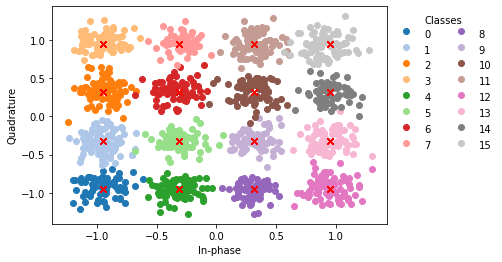

In [4]:
plot_symbols(X_train, y_train, symbs, QAM_modulation=M)

## Classifiers

### Random Forest

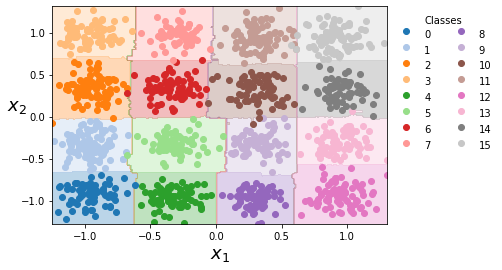

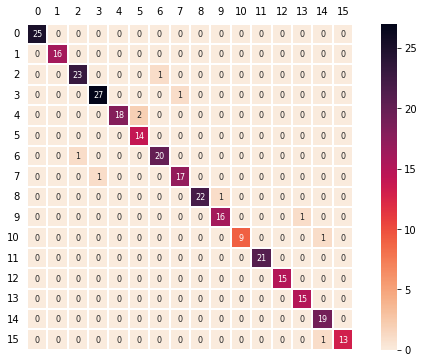

<module 'matplotlib.pyplot' from '/home/tiago/aldebson/lib/python3.8/site-packages/matplotlib/pyplot.py'>

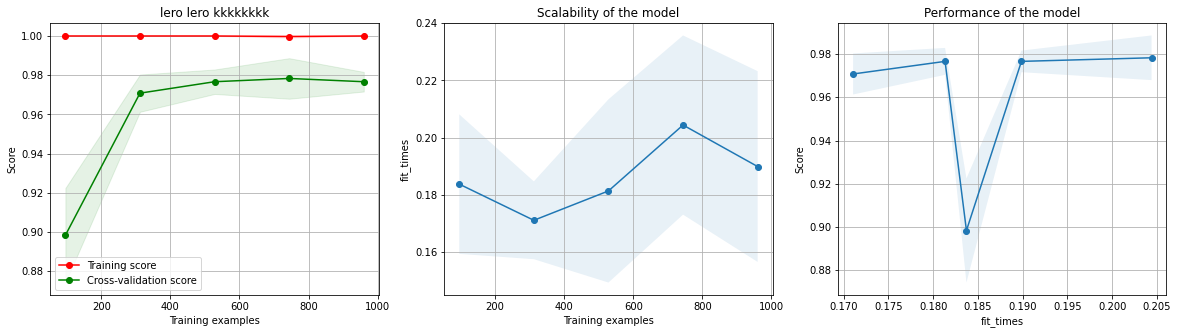

In [5]:
clf_RF = RandomForestClassifier(max_depth=RF_MAX_DEPTH, n_estimators=RF_NUM_ESTIMATORS, n_jobs=-1).fit(X_train, y_train)
plot_decision_boundary(clf_RF, X_train, y_train, legend=True)
plot_confusion_matrix(clf_RF, X_test, y_test, M)
plot_learning_curve(estimator=clf_RF,title="lero lero kkkkkkkk", X=X_train, y=y_train, n_jobs=-1)

In [6]:
clf_RF_ser = ser(clf_RF, X_test, y_test)
print(f'Random Forest:\n SER:\t {clf_RF_ser:.2%}')

Random Forest:
 SER:	 3.33%


### K-nearest neighbors

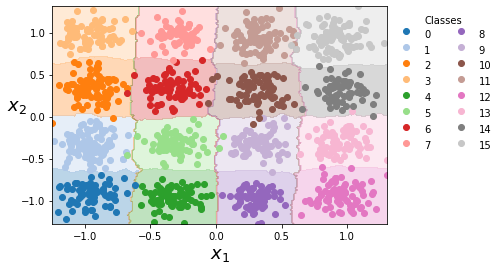

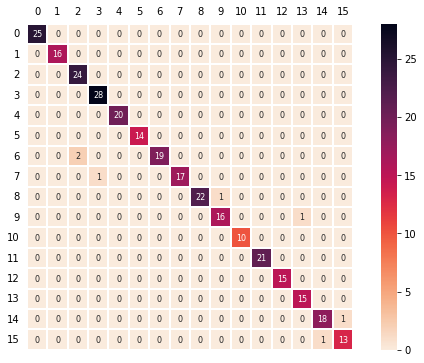

<module 'matplotlib.pyplot' from '/home/tiago/aldebson/lib/python3.8/site-packages/matplotlib/pyplot.py'>

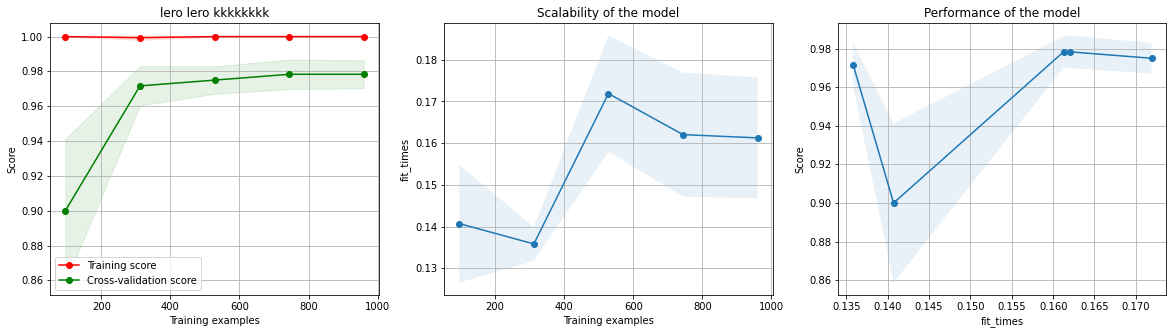

In [7]:
clf_KNN = KNeighborsClassifier(n_neighbors=KNN_NUM_NEIGHBORS, n_jobs=-1).fit(X_train, y_train)
plot_decision_boundary(clf_KNN, X_train, y_train, legend=True)
plot_confusion_matrix(clf_KNN, X_test, y_test, M)
plot_learning_curve(estimator=clf_RF,title="lero lero kkkkkkkk", X=X_train, y=y_train, n_jobs=-1)

In [8]:
clf_KNN_ser = ser(clf_KNN, X_test, y_test)
print(f'K-nearest neighbors:\n SER:\t {clf_KNN_ser:.2%}')

K-nearest neighbors:
 SER:	 2.33%
